# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías Ramundo

In [301]:
# loading libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve


### Entre cada uno de los integrantes del grupo fuimos obteniendo distintos features que nos parecieron interesantes y que consideramos que podrian servir para las predicciones.

#### Leemos los distintos CSVs que contienen los features

In [302]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv')
features_ari = pd.read_csv('../features/features_ariel.csv')
features_mati = pd.read_csv('../features/features_frecuencia.csv')
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')
features_gonza2 = pd.read_csv('../features/features_gonza2.csv')

### Mergeamos todos los features en un solo dataframe de la forma <persona, feature1, feature2,...,featureN>

In [303]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza2, how='inner', on='person')
#model_df = pd.merge(model_df, features_mati, how='inner', on='person')
model_df.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,generic listing,searched products,viewed product,visited site,completa_flujo,cantidad_lead_y,favorite_device_Computer,favorite_device_Smartphone,favorite_device_Tablet,favorite_device_Unknown
0,0008ed71,1,0,0,0,0,0,0,0,0,...,1.0,NaN,NaN,2.0,False,NaN,1,0,0,0
1,00091926,1,0,0,0,0,0,0,0,0,...,NaN,NaN,372.0,34.0,False,NaN,1,0,0,0
2,00091a7a,1,0,0,0,0,0,0,0,0,...,NaN,NaN,3.0,1.0,False,NaN,0,1,0,0
3,000ba417,0,0,0,0,0,0,0,1,0,...,14.0,NaN,153.0,6.0,False,NaN,1,0,0,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,1.0,9.0,3.0,1.0,False,NaN,0,1,0,0


### Al dataframe de las personas con sus features le agregamos los labels que contienen la informacoin si una persona realizara una compro o no

### Tambien tenemos un dataframe de test, el cual contiene todas las personas que queremos predecir y sus features ( queremos predecir sus labels)

In [304]:
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')

### El siguiente array contiene los features que seran tenidos en cuenta para correr los algoritmos, simplemente vamos comentando los features que no aportan nada al modelo o lo empeoran.

In [305]:
features = ['cant_total_eventos', #f1
            #'marca_favorita_apple',#f2
            'mean_events_per_day',#f3
            #'has_converted_before',#f4
            #'most_viewed_sku',#f5
            #'most_viewed_color_Preto',#f6
            #'most_viewed_color_Branco',#f7
            #'most_viewed_color_Dourado', #f8
            #'region_brasil_Sao Paulo',#f9
            #'region_brasil_Unknown',#f10
            #'region_brasil_Minas Gerais',#f11
            #'marca_favorita_samsung',#f12
            #'cant_ev_noche',#f13
            #'cant_ev_manana',#f14
            #'cant_ev_tarde',#f15
            #'cant_ev_madrugada',#f16
            #'cant_buenos',#f17
            #'cant_muy_buenos',#f18
            #'cant_excelentes',#f19
            #'nivel_de_actividad_Muy Bajo',#f20
            #'nivel_de_actividad_Muy Alto',#f21
            'nivel_de_actividad_Bajo',#f22
            'nivel_de_actividad_Medio',#f23
            'nivel_de_actividad_Alto',#f24
            #'favorite_device_Smartphone',#f25
            'favorite_device_Computer',#f26
            'cantidad_checkouts',#f27
            'cantidad_conversions',#f28
            'tasa_cc',
            'viewed product',
            #'cantidad_lead',
            #'searched products',
            #'first_and_last_event_distance_in_days',
            'month_moda',
            #'dias_distintos_con_eventos',
            #'eventos_totales_generados'
            #'completa_flujo'
            #'cant_modelo_iphone',
            #'cant_modelo_samsung',
            #'cant_modelo_motorola',
            #'cant_modelo_otro',
            #'porcentaje_modelo_iphone', 
            #'porcentaje_modelo_samsung',
            #'porcentaje_modelo_motorola', 
            #'porcentaje_modelo_otro',
            #'modelo_moda',
            'interest_last_151_days',
            'interest_last_4_days',
            'interest_last_6_days',
            'interest_last_8_days',
            'interest_last_10_days',
            'interest_last_12_days',
            'interest_last_14_days',
            'interest_last_16_days',
            'interest_last_18_days',
            'interest_last_20_days',
            'interest_last_22_days',
            'interest_last_24_days',
            'interest_last_26_days',
            'interest_last_28_days',
            'interest_last_30_days'
           ]

### Dividimos el set de entrenamiento en dos arrays, x contendra los usuarios con los features a utilizar e 'y' contendra las labels de los usuarios.

### Finalmente tenemos un tercer array llamado z el cual utilizaremos para la prediccion final

In [306]:
x = np.array(training_set[features])
y = np.array(training_set['label'])
z = np.array(test_set[features])


### Para tunear los hiperparametros usaremos un set de entrenamiento reducido

In [307]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

### El siguiente metodo llamado modelfit, recibe como parametro un modelo y realizara un fit con el set reducido de entrenamiento, finalmente imprimira por pantalla los distintos scores obtenidos

In [308]:
def modelfit(model):
    model.fit(X_train, y_train, eval_metric='aucpr')
    pred = (model.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, pred.round(), normalize=False)
    pred_proba = pred
    print("Accuracy: ", accuracy / float(pred.size))

    for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
        else: 
            pred[i] = 0

    print('---Classification Report---')
    print(classification_report(y_test,pred))
    print('AUROC :' + str(roc_auc_score(y_test, pred_proba)))

### XGBOOST

### Corremos xgboost con los siguientes hiperparametros y vemos su puntaje

In [280]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.9101210404326552)
---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.95      0.95      3691
          1       0.18      0.22      0.20       192

avg / total       0.92      0.91      0.92      3883

AUROC :0.5848862379210693


### Definimos un diccionario de distintos hiperparametros con varios valores posibles

In [281]:
param_test = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'learning_rate':[0, 0.001, 0.01, 0.1, 0.2],
}

In [282]:
xgb1 = xgb.XGBClassifier(objective='binary:logistic',
                        ntrhead=-1,
                        scale_post_weight=18)

### Realizamos un RandomizedSearchCV

In [283]:
random = RandomizedSearchCV(estimator= xgb1, param_distributions=param_test,
                           n_iter = 100, cv = 3, verbose = 2, random_state = 42,
                           n_jobs=-1, scoring='roc_auc')
random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] colsample_bytree=0.7, learning_rate=0.01, min_child_weight=3, n_estimators=1800, subsample=0.9, max_depth=9, gamma=0.1 
[CV] colsample_bytree=0.7, learning_rate=0.01, min_child_weight=3, n_estimators=1800, subsample=0.9, max_depth=9, gamma=0.1 
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=1, n_estimators=1200, subsample=0.6, max_depth=9, gamma=0.0 
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=1, n_estimators=1200, subsample=0.6, max_depth=9, gamma=0.0 
[CV] colsample_bytree=0.7, learning_rate=0.01, min_child_weight=3, n_estimators=1800, subsample=0.9, max_depth=9, gamma=0.1 
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=1, n_estimators=1200, subsample=0.6, max_depth=9, gamma=0.0 
[CV] colsample_bytree=0.9, learning_rate=0.2, min_child_weight=5, n_estimators=2000, subsample=0.8, max_depth=5, gamma=0.0 
[CV] colsample_bytree=0.9, learning_rate=0.2, min_child_weig

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.3s


[CV]  colsample_bytree=0.9, learning_rate=0.001, min_child_weight=5, n_estimators=600, subsample=0.9, max_depth=9, gamma=0.3, total=   8.9s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=3, n_estimators=1200, subsample=0.9, max_depth=5, gamma=0.1 
[CV]  colsample_bytree=0.9, learning_rate=0.01, min_child_weight=5, n_estimators=1800, subsample=0.8, max_depth=5, gamma=0.0, total=  19.7s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=3, n_estimators=1200, subsample=0.9, max_depth=5, gamma=0.1 
[CV]  colsample_bytree=0.9, learning_rate=0.1, min_child_weight=1, n_estimators=1600, subsample=0.9, max_depth=5, gamma=0.4, total=  16.5s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=3, n_estimators=1200, subsample=0.9, max_depth=5, gamma=0.1 
[CV]  colsample_bytree=0.9, learning_rate=0.01, min_child_weight=5, n_estimators=1800, subsample=0.8, max_depth=5, gamma=0.0, total=  20.0s
[CV] colsample_bytree=0.9, learning_rate=0, min_child_weight=3, n_est

[CV] colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=800, subsample=0.7, max_depth=9, gamma=0.1 
[CV]  colsample_bytree=0.7, learning_rate=0.001, min_child_weight=5, n_estimators=600, subsample=0.7, max_depth=3, gamma=0.3, total=   3.9s
[CV] colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=800, subsample=0.7, max_depth=9, gamma=0.1 
[CV]  colsample_bytree=0.7, learning_rate=0.001, min_child_weight=5, n_estimators=600, subsample=0.7, max_depth=3, gamma=0.3, total=   3.9s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=2000, subsample=0.6, max_depth=5, gamma=0.2 
[CV]  colsample_bytree=0.9, learning_rate=0.1, min_child_weight=1, n_estimators=1000, subsample=0.9, max_depth=9, gamma=0.0, total=  20.1s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=2000, subsample=0.6, max_depth=5, gamma=0.2 
[CV]  colsample_bytree=0.9, learning_rate=0.001, min_child_weight=3, n_estimators=1600,

[CV]  colsample_bytree=0.7, learning_rate=0.1, min_child_weight=3, n_estimators=1600, subsample=0.9, max_depth=5, gamma=0.2, total=  19.4s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=5, n_estimators=1000, subsample=0.9, max_depth=9, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0, min_child_weight=3, n_estimators=1600, subsample=0.7, max_depth=5, gamma=0.0, total=  13.2s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=5, n_estimators=1000, subsample=0.9, max_depth=9, gamma=0.0 
[CV]  colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=800, subsample=0.7, max_depth=7, gamma=0.4, total=  12.4s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=5, n_estimators=1000, subsample=0.9, max_depth=9, gamma=0.0 
[CV]  colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=800, subsample=0.7, max_depth=7, gamma=0.4, total=  12.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimat

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1400, subsample=0.9, max_depth=3, gamma=0.4 
[CV]  colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1400, subsample=0.9, max_depth=3, gamma=0.4 
[CV]  colsample_bytree=0.7, learning_rate=0, min_child_weight=5, n_estimators=1200, subsample=0.8, max_depth=3, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=1800, subsample=0.6, max_depth=5, gamma=0.3 
[CV]  colsample_bytree=0.8, learning_rate=0.2, min_child_weight=1, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=1800, subsample=0.6, max_depth=5, gamma=0.3 
[CV]  colsample_bytree=0.7, learning_rate=0, min_child_weight=3, n_estimators=1000, sub

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min


[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=5, n_estimators=1000, subsample=0.6, max_depth=9, gamma=0.4, total=  13.4s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=200, subsample=0.9, max_depth=9, gamma=0.4 
[CV]  colsample_bytree=0.7, learning_rate=0.2, min_child_weight=1, n_estimators=1000, subsample=0.7, max_depth=9, gamma=0.4, total=  15.9s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=200, subsample=0.9, max_depth=9, gamma=0.4 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=1, n_estimators=1800, subsample=0.7, max_depth=7, gamma=0.3, total=  22.5s
[CV] colsample_bytree=0.7, learning_rate=0, min_child_weight=5, n_estimators=2000, subsample=0.9, max_depth=7, gamma=0.2 
[CV]  colsample_bytree=0.7, learning_rate=0.2, min_child_weight=1, n_estimators=1000, subsample=0.7, max_depth=9, gamma=0.4, total=  15.9s
[CV] colsample_bytree=0.7, learning_rate=0, min_child_weight=5, n_estimato

[CV] colsample_bytree=0.7, learning_rate=0, min_child_weight=1, n_estimators=1000, subsample=0.7, max_depth=7, gamma=0.3 
[CV]  colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=1400, subsample=0.7, max_depth=5, gamma=0.0, total=  12.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.7, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.1, min_child_weight=1, n_estimators=1400, subsample=0.7, max_depth=5, gamma=0.0, total=  12.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.7, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.7, learning_rate=0.2, min_child_weight=3, n_estimators=1000, subsample=0.9, max_depth=9, gamma=0.4, total=  14.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.7, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.7, learning_rate=0.2, min_child_weight=3, n_estimators=1000, 

[CV]  colsample_bytree=0.6, learning_rate=0, min_child_weight=3, n_estimators=200, subsample=0.7, max_depth=5, gamma=0.0, total=   1.7s
[CV] colsample_bytree=0.9, learning_rate=0.01, min_child_weight=5, n_estimators=1400, subsample=0.7, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0, min_child_weight=3, n_estimators=200, subsample=0.7, max_depth=5, gamma=0.0, total=   1.6s
[CV] colsample_bytree=0.9, learning_rate=0.01, min_child_weight=5, n_estimators=1400, subsample=0.7, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0, min_child_weight=3, n_estimators=200, subsample=0.7, max_depth=5, gamma=0.0, total=   1.6s
[CV] colsample_bytree=0.8, learning_rate=0, min_child_weight=1, n_estimators=2000, subsample=0.7, max_depth=5, gamma=0.1 
[CV]  colsample_bytree=0.9, learning_rate=0.01, min_child_weight=5, n_estimators=1400, subsample=0.7, max_depth=3, gamma=0.0, total=   9.4s
[CV] colsample_bytree=0.8, learning_rate=0, min_child_weight=1, n_estimators=200

[CV] colsample_bytree=0.8, learning_rate=0, min_child_weight=1, n_estimators=2000, subsample=0.6, max_depth=7, gamma=0.0 
[CV]  colsample_bytree=0.9, learning_rate=0.2, min_child_weight=3, n_estimators=2000, subsample=0.7, max_depth=3, gamma=0.1, total=  14.0s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=400, subsample=0.9, max_depth=5, gamma=0.4 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1000, subsample=0.6, max_depth=3, gamma=0.0, total=   5.8s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=400, subsample=0.9, max_depth=5, gamma=0.4 
[CV]  colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=400, subsample=0.9, max_depth=5, gamma=0.4, total=   3.4s
[CV] colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=400, subsample=0.9, max_depth=5, gamma=0.4 
[CV]  colsample_bytree=0.7, learning_rate=0.1, min_child_weight=5, n_estimators=400, subsamp

[CV]  colsample_bytree=0.7, learning_rate=0, min_child_weight=3, n_estimators=1400, subsample=0.7, max_depth=5, gamma=0.0, total=  11.7s
[CV] colsample_bytree=0.9, learning_rate=0.1, min_child_weight=1, n_estimators=1000, subsample=0.6, max_depth=5, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=600, subsample=0.9, max_depth=9, gamma=0.3, total=   8.4s
[CV]  colsample_bytree=0.9, learning_rate=0.001, min_child_weight=5, n_estimators=1000, subsample=0.9, max_depth=5, gamma=0.1, total=   9.9s
[CV] colsample_bytree=0.9, learning_rate=0.1, min_child_weight=1, n_estimators=1000, subsample=0.6, max_depth=5, gamma=0.1 
[CV] colsample_bytree=0.9, learning_rate=0.2, min_child_weight=1, n_estimators=400, subsample=0.6, max_depth=5, gamma=0.0 
[CV]  colsample_bytree=0.9, learning_rate=0.001, min_child_weight=5, n_estimators=1000, subsample=0.9, max_depth=5, gamma=0.1, total=  10.1s
[CV] colsample_bytree=0.9, learning_rate=0.2, min_child_weight=1, n_est

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, ntrhead=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scale_post_weight=18, seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'learning_rate': [0, 0.001, 0.01, 0.1, 0.2], 'min_child_weight': [1, 3, 5], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'subsample': [0.6, 0.7, 0.8, 0.9], 'max_depth': [3, 5, 7, 9], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2

### Con los nuevos hiperparametros que obtuvimos, realizamos nuevamente un modelfit y observamos el nuevo roc_auc_score

In [293]:
#random.best_params_

#{'colsample_bytree': 0.6,
# 'gamma': 0.0,
# 'learning_rate': 0.01,
# 'max_depth': 3,
# 'min_child_weight': 3,
# 'n_estimators': 1000,
# 'subsample': 0.6}

In [294]:
xgb_randomized_cv = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=18,
    colsample_bytree=0.6,
    gamma=0,
    learning_rate =0.01,
    max_depth=3,
    min_child_weight=3,
    n_estimators=1000,
    subsample=0.6
)
modelfit(xgb_randomized_cv)

('Accuracy: ', 0.7787792943600309)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.78      0.87      3689
          1       0.15      0.71      0.24       194

avg / total       0.94      0.78      0.84      3883

AUROC :0.7468330198723987


###  En base a los hiperparametros obtenidos con RandomSearch construimos un nuevo diccionario de hiperparametros a probar para esta vez hacer un GridSearch

In [231]:
param_test = {
    'n_estimators': [int(x) for x in np.linspace(start = 800, stop = 1200, num = 10)],
    'max_depth':range(2,4,1),
    'min_child_weight':range(2,4,1),
    'gamma':[i/10.0 for i in range(0,3)],
    'subsample':[i/10.0 for i in range(5,7)],
    'colsample_bytree':[i/10.0 for i in range(5,7)],
    'learning_rate':[0.001, 0.01],
}

In [191]:
gsearch = GridSearch(verbose =2, estimator = xgb1,param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=3)
gsearch.fit(X_train, y_train)
gsearch.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0 
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_wei

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.1s


[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.0, total=   6.0s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.0, total=   6.0s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weig

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   4.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   4.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.0, total=   7.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   4.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.0, total=   6.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.0, total=   6.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.0, total=   6.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_we

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.0, total=   7.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0, total=   6.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min


[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0, total=   8.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0, total=   8.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weig

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0, total=  10.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0, total=   6.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0, total=  10.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weigh

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0, total=   8.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0, total=   8.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0, total=   8.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_we

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   4.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0, total=  10.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0, total=  10.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.0, total=   6.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.0, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   4.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, s

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.5min


[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.0, total=   7.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.0, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0, total=   7.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0, total=   7.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.0, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.0, total=   8.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.0, total=   8.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977,

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.0, total=  10.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.0, total=  10.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0, total=  10.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=12

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.0, total=   8.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0, total=   8.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0, total=   8.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0, total=  10.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0, total=  10.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   4.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0, total=  10.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.1, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.1, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weig

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   4.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   4.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weigh

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.0s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   5.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1, total=   6.0s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_wei

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1, total=   7.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1, total=   7.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weigh

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.1, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.2min


[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1, total=   8.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   8.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   8.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   8.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   6.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   6.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.1, total=   7.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   8.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   8.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1, total=   8.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1, total=   8.8s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1, total=   5.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1, total=   6.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.1, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.1, total=   5.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.1, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_est

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.1, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.1, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.1, total=   6.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1, total=   7.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1, total=   7.7s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1, total=   9.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1, total=   9.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.1, total=   9.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.1, total=   7.7s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_est

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.1, total=   9.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.1, total=   9.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.1, total=   9.8s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators

[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2, total=   5.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2, total=   5.7s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimator

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 16.3min


[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2, total=   5.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2, total=   5.0s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.5s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.2, total=   6.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   7.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   7.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   7.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   7.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=   9.1s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=   9.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=   9.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=   9.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   7.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   7.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   7.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.2, total=   7.6s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=   9.3s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=   9.2s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2, total=   9.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2, total=   9.4s
[CV] colsample_bytree=0.5, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.2, total=   5.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2, total=   5.6s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2, total=   5.5s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2, total=   6.8s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2, total=   5.7s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2, total=   5.7s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.2, total=   5.8s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_est

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2, total=   7.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2, total=   7.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.2, total=   7.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2, total=   8.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2, total=   8.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=933, 

[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2, total=  10.0s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2, total=  10.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2, total=   9.9s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=2, n_estimators=1

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.2, total=   8.1s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.2, total=   8.3s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.2, total=   8.2s
[CV] colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_

[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.2, total=  10.2s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.2, total=  10.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.0, total=   5.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.2, total=  10.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 23.6min


[CV]  colsample_bytree=0.5, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=  10.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.0, total=   5.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0, total=   5.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.0, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.0, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.0, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0, total=   7.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0, total=   8.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0, total=   8.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.0, total=   8.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0, total=  10.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.0, total=  11.2s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.0, total=  11.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.0, total=  12.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.0, total=   7.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.0, total=   8.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.0, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.0, total=   7.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.0, total=   9.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.0, total=   9.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.0, total=   9.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.0, total=  10.2s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0, total=   5.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.0, total=   5.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0, total=   5.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0, total=   7.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0, total=   7.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.0, total=   7.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.0, total=   6.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.0, total=   5.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_est

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.0, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.0, total=   7.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.0, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0, total=   8.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.0, total=   8.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.0, total=   8.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.0, total=   8.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_est

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.0, total=  10.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0, total=  10.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0, total=  10.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0, total=  10.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.0, total=   8.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.0, total=   8.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.0, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=933, s

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.0, total=  10.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.0, total=  11.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.0 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.0, total=  11.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators

[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.2s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimat

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 32.9min


[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.1, total=   7.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.5, max_depth=2, gamma=0.1, total=   6.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=933, subsample=0.6, max_depth=2, gamma=0.1, total=   6.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.6, max_depth=2, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=2, gamma=0.1, total=   7.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_we

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.1, total=   8.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.6, max_depth=3, gamma=0.1, total=   8.7s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weig

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.6, max_depth=3, gamma=0.1, total=  10.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1, total=  10.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1, total=  11.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1, total=  10.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_wei

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.5, max_depth=3, gamma=0.1, total=   8.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.1, total=   9.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weig

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1, total=  11.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.5, max_depth=3, gamma=0.1, total=  11.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   5.2s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.1, total=  11.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2,

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=10

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   5.2s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.1, total=   8.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.1, total=   5.2s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200,

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=2, gamma=0.1, total=   6.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.1, total=   6.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3,

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1, total=   7.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.1, total=   7.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.1, total=   9.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   9.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   9.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.1, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, s

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   9.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=3, gamma=0.1, total=   9.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1, total=  10.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.1 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.1, total=  10.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2, total=   5.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2, total=   5.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2, total=   5.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   7.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   8.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   8.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   9.0s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=933, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2, total=   8.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=  10.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=  10.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=  10.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2, total=  10.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 43.7min


[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=  12.8s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=  13.5s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=800, subsample=0.5, max_depth=3, gamma=0.2, total=   8.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weigh

[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.2, total=  10.6s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2, total=  10.3s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=977, subsample=0.6, max_depth=3, gamma=0.2, total=  11.1s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1022, subsample=0.5, max_depth=3, gamma=0.2, total=  10.9s
[CV] colsample_bytree=0.6, learning_rate=0.001, min_child_we

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.2, total=   5.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=  12.5s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.5, max_depth=2, gamma=0.2, total=   6.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.001, min_child_weight=3, n_estimators=1200, subsample=0.6, max_depth=3, gamma=0.2, total=  12.7s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.2, total=   7.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.5, max_depth=2, gamma=0.2, total=   7.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.2, total=   7.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1200, subsample=0.6, max_depth=2, gamma=0.2, total=   8.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.2, total=   5.4s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, subsample=0.6, max_depth=2, gamma=0.2, total=   5.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=800, 

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.2, total=   7.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.2, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1022, subsample=0.6, max_depth=2, gamma=0.2, total=   6.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.5, max_depth=2, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=2, gamma=0.2, total=   6.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.2, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=800, subsample=0.6, max_depth=3, gamma=0.2, total=   7.6s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2, total=   8.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_est

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2, total=   9.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2, total=   9.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2, total=  10.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=2, n_estimators

[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.5, max_depth=3, gamma=0.2, total=   7.9s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, subsample=0.6, max_depth=3, gamma=0.2, total=   8.0s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=888, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=844, s

[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.5, max_depth=3, gamma=0.2, total=   9.8s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=  10.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1111, subsample=0.6, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=  10.1s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1155, subsample=0.5, max_depth=3, gamma=0.2 
[CV]  colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3, n_estimators=1066, subsample=0.6, max_depth=3, gamma=0.2, total=  10.3s
[CV] colsample_bytree=0.6, learning_rate=0.01, min_child_weight=3

[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 49.5min finished


NameError: name 'gsearch1' is not defined

In [309]:
gsearch.best_params_

#{'colsample_bytree': 0.6,
# 'gamma': 0.1,
# 'learning_rate': 0.01,
# 'max_depth': 3,
# 'min_child_weight': 3,
# 'n_estimators': 844,
# 'subsample': 0.5}

{'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 844,
 'subsample': 0.5}

In [310]:
xgb_grids = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=18,
    colsample_bytree=0.6,
    gamma=0.1,
    learning_rate =0.01,
    max_depth=3,
    min_child_weight=3,
    n_estimators=844,
    subsample=0.5
)
modelfit(xgb_grids)

('Accuracy: ', 0.7836724182333248)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.79      0.87      3681
          1       0.16      0.76      0.27       202

avg / total       0.94      0.78      0.84      3883

AUROC :0.7712692418386093


### Una vez que fiteamos el modelo con sus hiperparametros, ploteamos la importancia de los features para el modelo

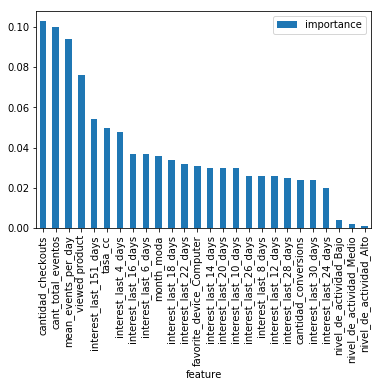

In [311]:
importances = pd.DataFrame({'feature':features,'importance':np.round(xgb_grids.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

### Finalmente entrenamos este ultimo para el dataset entero y predecimos la probabilidad de que una persona realice o no una compra

In [ ]:
xgb_grids.fit(x,y)
pred = xgb_grids.predict_proba(z)[:,1]

In [ ]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)